In [1]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.client import device_lib
import tensorflow as tf
import keras
!python3 --version
print(device_lib.list_local_devices()[1])
print('tensorflow version: ',tf.__version__)
print('keras version: ',keras.__version__)

Python 3.6.3


Using TensorFlow backend.


name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10968950375
locality {
  bus_id: 1
}
incarnation: 16360196834862020854
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0e:00.0, compute capability: 6.1"

tensorflow version:  1.4.1
keras version:  2.1.3


In [2]:
# processing module
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import cv2
import os
import shutil

維護資料夾的結構

In [3]:
os.chdir('/home/jovyan/data')
!rm -r train
!rm -r validation
!cp -r train_save train
!ls

img-submission.csv    pipline.csv     testset  train_save
mid_term_mapping.txt  submission.csv  train


In [4]:
# training module
import tensorflow as tf
from keras import models, layers, optimizers
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

建立pipline

In [5]:
classnum = os.listdir('train/')
pipline = pd.DataFrame(columns=['classname','img'])
for i in range(len(classnum)):
    filename = os.listdir('train/' + classnum[i])
    data_dict = {'classname':np.repeat(classnum[i],len(filename)),
                 'img':[classnum[i] + '/' + v for v in filename]}
    data = pd.DataFrame(data=data_dict)
    pipline = pd.concat([pipline,data],axis=0,ignore_index=True)
pipline.to_csv('pipline.csv',index=False)

In [6]:
pipline = pd.read_csv('pipline.csv')
print(pipline.head())

    classname                        img
0  industrial  industrial/image_0018.jpg
1  industrial  industrial/image_0126.jpg
2  industrial  industrial/image_0181.jpg
3  industrial  industrial/image_0196.jpg
4  industrial  industrial/image_0172.jpg


觀察照片的種類及數量

In [7]:
pipline.classname.value_counts()

opencountry     310
mountain        274
coast           260
tallbuilding    256
forest          228
store           215
industrial      211
insidecity      209
street          192
livingroom      189
highway         160
CALsuburb       141
bedroom         116
PARoffice       115
kitchen         110
Name: classname, dtype: int64

觀察其第一張照片的屬性

In [8]:
img = cv2.imread('train/' + pipline.img[0])
print(img.shape)

(268, 220, 3)


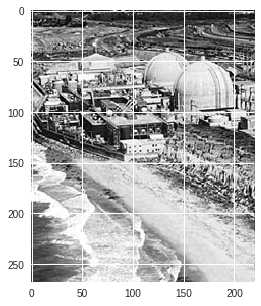

In [9]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.show()

設定參數

In [10]:
img_width, img_height = 256,256 # 使用訓練圖片最多的`pixel_pair`
train_data_dir = 'train/' # 建立連結，預備給後面的`flow_from_directory`使用
valid_data_dir = 'validation/'
batch_size = 3 # 每次訓練幾筆
num_class = 15
lr = 1e-4
momentum=0.9 # optimizer使用SGD，所以這裏需要設定momentum
epoch=30 # 整筆資料訓練幾次

建立validation資料夾與底下的資料夾，透過複製train資料夾來完成同樣的結構

In [11]:
os.chdir('/home/jovyan/data')
source_dir = 'train/'
valid_dir = 'validation/'

!cp -r train validation

In [12]:
# 從training set中抽20%的圖片放到validation folder的各個種類資料夾
img_species = np.unique(pipline.classname)

for i in range(len(img_species)):
    print(img_species[i])
    folder_img = os.listdir('train/' + img_species[i])
    valid_img = np.random.choice(folder_img, int(np.floor(len(folder_img)*0.2)),replace=False)
    os.chdir('/home/jovyan/data/validation/' + str(img_species[i]))
    !rm -r *.jpg  # 刪除validation裡面原本的照片
    os.chdir('/home/jovyan/data')
    for j in range(len(valid_img)):
        shutil.move('train/' + img_species[i] + '/' + valid_img[j], valid_dir + img_species[i])

CALsuburb
PARoffice
bedroom
coast
forest
highway
industrial
insidecity
kitchen
livingroom
mountain
opencountry
store
street
tallbuilding


把惹人厭的.ipynb_checkpoints刪除(會影響讀檔)

In [13]:
os.chdir('/home/jovyan/data/train/')
!rm -r .ipynb_checkpoints
os.chdir('/home/jovyan/data')

os.chdir('/home/jovyan/data/validation/')
!rm -r .ipynb_checkpoints
os.chdir('/home/jovyan/data')

透過ImageDataGenerator來把資料擴充

    rotation_range：將圖片隨機選轉$[0,\theta]$內的角度。
    rescale：縮小圖片的倍數，通常會使用1./255，因為像素範圍是0~255。
    shear_range：讓圖片傾斜的比例，讓所有X座標(或是Y座標)保持不變，對應的Y座標(或是X座標)按比例發生平移。
    zoom_range：此參數可以讓圖片的長或寬進行縮放，可以輸入一個數值或是list，若為數值，則兩軸按同樣比例縮放，若為list，則是[width_zoom_range,height_zoom_range]表示進行長寬進行不同比例縮放。
    horizontal_flip：若為True，則隨機對圖片進行水平翻轉操作，通常不會進行垂直翻轉，因為圖片若垂直翻轉通常沒有意義。


In [14]:
train_datagen = ImageDataGenerator(rotation_range=30, 
                                   rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_datagen = ImageDataGenerator(rescale=1./255)  # 把顏色除255 使得數值介於0~1
valid_generator = valid_datagen.flow_from_directory(valid_data_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

Found 2392 images belonging to 15 classes.
Found 593 images belonging to 15 classes.


In [15]:
train_generator.class_indices # 觀察每個類別的labelencoder

{'CALsuburb': 0,
 'PARoffice': 1,
 'bedroom': 2,
 'coast': 3,
 'forest': 4,
 'highway': 5,
 'industrial': 6,
 'insidecity': 7,
 'kitchen': 8,
 'livingroom': 9,
 'mountain': 10,
 'opencountry': 11,
 'store': 12,
 'street': 13,
 'tallbuilding': 14}

建立我們自己的全連接層

In [16]:
fc1_hidden = 512
fc2_hidden = 256
fc3_hidden = 128
num_class = 15

使用Xception模型，但不使用他的全連接層(他的資料量太多了，他的資料量是120萬分1000類)

In [17]:
Xception_base = applications.Xception(weights='imagenet', include_top=False)

x = Xception_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(fc1_hidden,activation='relu')(x)
x = layers.Dense(fc2_hidden,activation='relu')(x)
x = layers.Dense(fc3_hidden,activation='relu')(x)

predictions = layers.Dense(num_class, activation='softmax')(x)

Xception_transfer = models.Model(inputs=Xception_base.input, outputs=predictions)

Xception_transfer.compile(loss = 'categorical_crossentropy',
                           optimizer = optimizers.SGD(lr=lr, momentum=momentum),
                           metrics=['accuracy'])


In [18]:
Xception_transfer.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

開始學習

In [19]:
with tf.device('/device:GPU:1'):
    history_Xception = Xception_transfer.fit_generator(train_generator,epochs=epoch,shuffle=True,verbose=1,validation_data=valid_generator)

Epoch 1/30
798/798 [==============================] - 59s 74ms/step - loss: 2.6902 - acc: 0.0873 - val_loss: 2.6635 - val_acc: 0.1164
Epoch 2/30
798/798 [==============================] - 55s 69ms/step - loss: 2.6210 - acc: 0.1324 - val_loss: 2.5584 - val_acc: 0.1400
Epoch 3/30
798/798 [==============================] - 56s 70ms/step - loss: 2.5406 - acc: 0.1470 - val_loss: 2.4456 - val_acc: 0.1602
Epoch 4/30
798/798 [==============================] - 56s 70ms/step - loss: 2.4857 - acc: 0.1642 - val_loss: 2.3795 - val_acc: 0.2125
Epoch 5/30
798/798 [==============================] - 56s 70ms/step - loss: 2.4034 - acc: 0.1955 - val_loss: 2.2680 - val_acc: 0.3035
Epoch 6/30
798/798 [==============================] - 56s 70ms/step - loss: 2.2897 - acc: 0.2348 - val_loss: 2.0784 - val_acc: 0.3002
Epoch 7/30
798/798 [==============================] - 56s 70ms/step - loss: 2.1404 - acc: 0.2974 - val_loss: 1.8506 - val_acc: 0.4890
Epoch 8/30
798/798 [==============================] - 56s 70ms

把模型的權重存起來

In [20]:
Xception_transfer.save_weights("/home/jovyan/Model/Xception_Model.h5")
print("Saved model")

Saved model


觀察loss和acc

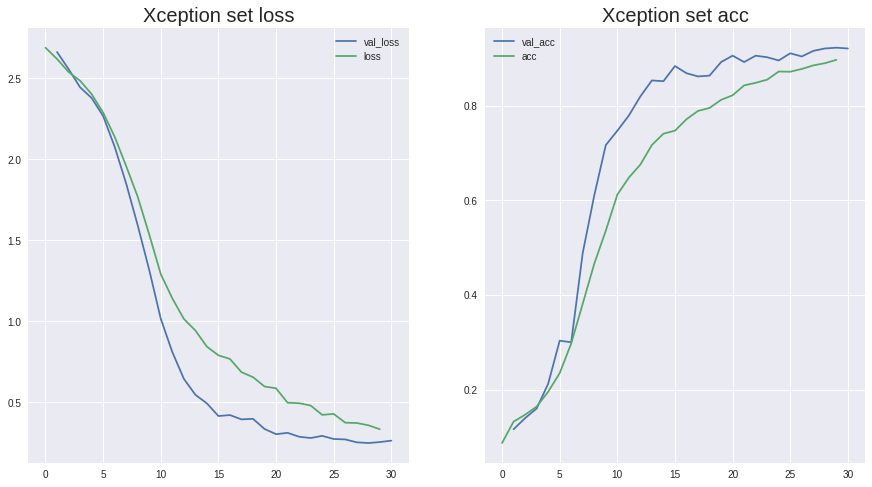

In [21]:
rcParams['figure.figsize']=(15,8)
plt.subplot(1,2,1)
plt.plot(np.arange(30)+1,history_Xception.history['val_loss'],history_Xception.history['loss'])
plt.legend(labels=['val_loss','loss'])
plt.title('Xception set loss',size=20)

plt.subplot(1,2,2)
plt.plot(np.arange(30)+1,history_Xception.history['val_acc'],history_Xception.history['acc'])
plt.legend(labels=['val_acc','acc'])
plt.title('Xception set acc',size=20)

plt.show()

再次把討厭的.ipynb_checkpoints刪除

In [22]:
os.chdir('/home/jovyan/data/testset/test')
!rm -r .ipynb_checkpoints
os.chdir('/home/jovyan/data')

rm: cannot remove '.ipynb_checkpoints': No such file or directory


把test讀進來

In [23]:
test= os.listdir('testset/test')

x_test = np.zeros((len(test), img_height, img_width, 3), dtype='float32')
for i in range(len(test)):
    gg = image.load_img('testset/test/' + test[i],target_size=(img_height, img_width))
    gg = image.img_to_array(gg) / 255
    x_test[i] = gg
print('Test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

Test Images shape: (1500, 256, 256, 3) size: 294,912,000


把test丟進模型裡面

In [24]:
prediction_prob = history_Xception.model.predict(x_test)

顯示結果

In [25]:
prediction = np.argmax(prediction_prob,axis=1)
prediction

array([13, 12,  6, ..., 11,  0,  0])

In [26]:
inverdict = {k:v for v,k in train_generator.class_indices.items()} # 將key與value對調
prediction = [inverdict.get(k) for k in prediction] # map

我們前面分類的encoding是ImageDataGenerator給的不是真正的encoding，所以要進行處理

In [27]:
correct_dict = {'kitchen':0,'street':1,'industrial':2,'insidecity':3,'forest':4,'livingroom':5,'opencountry':6,
                'PARoffice':7,'mountain':8,'CALsuburb':9,'coast':10,'store':11,'bedroom':12,'tallbuilding':13,
                'highway':14}

把答案存到submission裡面

In [28]:
submission = pd.DataFrame({'class':[correct_dict[k] for k in prediction], 'id':[i.split('.')[0] for i in test]})
submission = submission[['id','class']]

把submission匯出成submission.csv

In [29]:
submission.to_csv('submission.csv',index=False)

![](https://i.imgur.com/n0b8fdD.jpg)